## Portable Predictions: Learning Housing Prices Across Diverse Markets

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text

# Database URL
db_url = (
    "postgres://ufnbfacj9c7u80:"
    "pa129f8c5adad53ef2c90db10cce0c899f8c7bdad022cca4e85a8729b19aad68d"
    "@ceq2kf3e33g245.cluster-czrs8kj4isg7.us-east-1.rds.amazonaws.com:5432/d9f89h4ju1lleh"
)

# Fix dialect
db_url = db_url.replace("postgres://", "postgresql://")

# Create SQLAlchemy engine
engine = create_engine(db_url)

# Optional: Check total rows

with engine.connect() as connection:
    row_count = connection.execute(text("SELECT COUNT(*) FROM acs_pums;")).scalar()
    print(f"Total rows in acs_pums: {row_count:,}")

# SQL query
# - Pull only columns needed
# - Clean housing filters
# - Ensures required fields are NOT NULL

query = """
    SELECT 
        SERIALNO,
        VALP,
        TEN,
        HINCP,
        FINCP,
        BDS,
        YRBLT,
        NP,
        PUMA,
        REGION,
        rt
    FROM acs_pums
    WHERE
        TEN = 1                  -- Owner-occupied only
        AND VALP > 0             -- Valid property value
        AND HINCP IS NOT NULL
        AND FINCP IS NOT NULL
        AND BDS IS NOT NULL
        AND YRBLT IS NOT NULL
        AND NP IS NOT NULL
"""


# Load to DataFrame
print("Processing query...")
df_check = pd.read_sql(query, engine)


# Quick checks
print("\nSample rows:")
print(df_check.head(3))
print("\nRows, Columns:", df_check.shape)
print("\nColumns:", df_check.columns.tolist())

## Linear Regression (Baseline)

Final dataset shape: (3304047, 15)
   hincp_real  fincp_real  bds  np  house_age       valp   valp_log
0     50000.0     50000.0  3.0   2       42.0   175000.0  12.072547
1    235000.0    235000.0  5.0   2       22.0  2100000.0  14.557448
2     40100.0     40100.0  3.0   2       52.0   180000.0  12.100718
3    106400.0    106400.0  3.0   9       82.0   600000.0  13.304687
4    315000.0    315000.0  4.0   4       62.0   700000.0  13.458837
RMSE (log): 3.9603
R² (log): 0.0990

Model Coefficients:
      Feature  Coefficient
2         bds     0.181732
3          np    -0.090413
4   house_age    -0.001429
0  hincp_real     0.000006
1  fincp_real    -0.000002
Saved figure to: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/Linear_Regression_Final.png


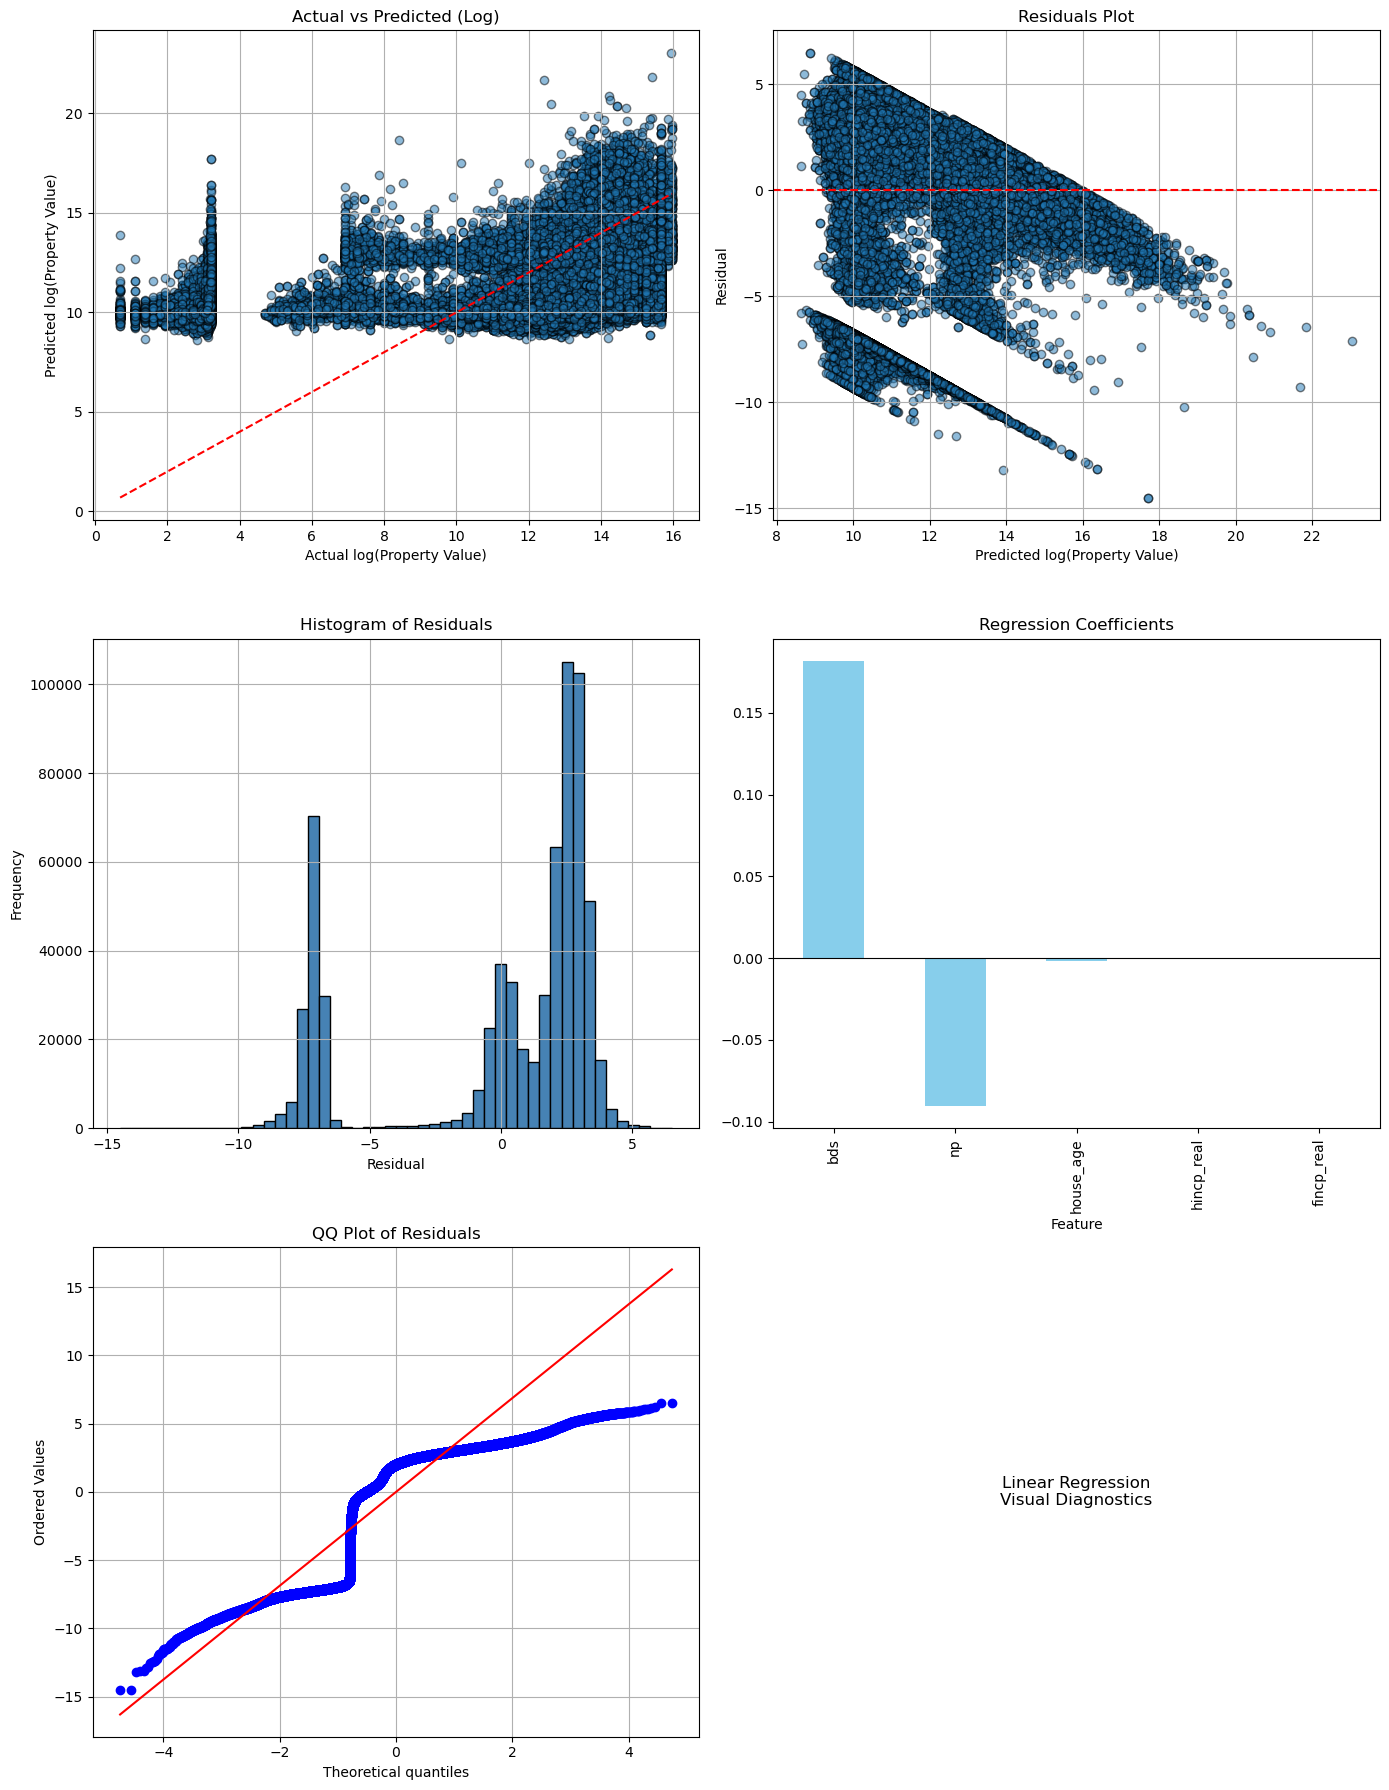

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# --------------------------
# 1) Clean working copy
# --------------------------
df = df_check.copy()

# Example: If your DataFrame has an 'acs_year' column, use that
if "acs_year" in df.columns:
    df["house_age"] = df["acs_year"] - df["yrblt"]
else:
    # If not, use a known constant year, like 2022
    survey_year = 2022
    df["house_age"] = survey_year - df["yrblt"]

# Income adjustments, if you have ADJINC
if "adjinc" in df.columns:
    df["hincp_real"] = df["hincp"] * df["adjinc"] / 1_000_000
    df["fincp_real"] = df["fincp"] * df["adjinc"] / 1_000_000
else:
    df["hincp_real"] = df["hincp"]
    df["fincp_real"] = df["fincp"]

# Filter valid rows
df = df[(df["valp"] > 0) & (df["ten"] == 1)]

features = ["hincp_real", "fincp_real", "bds", "np", "house_age"]
df = df.dropna(subset=features + ["valp"])

df["valp_log"] = np.log(df["valp"] + 1)

print(f"Final dataset shape: {df.shape}")
print(df[features + ["valp", "valp_log"]].head())

# --------------------------
# 2) Split
# --------------------------
X = df[features]
y = df["valp_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 3) Train
# --------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# --------------------------
# 4) Evaluate
# --------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE (log): {rmse:.4f}")
print(f"R² (log): {r2:.4f}")

coef = pd.DataFrame({"Feature": features, "Coefficient": lr.coef_}).sort_values(
    by="Coefficient", key=abs, ascending=False
)

print("\nModel Coefficients:")
print(coef)

# --------------------------
# 5) Visuals & Save
# --------------------------
residuals = y_test - y_pred

fig, axs = plt.subplots(3, 2, figsize=(14, 18))

axs[0, 0].scatter(y_test, y_pred, alpha=0.5, edgecolor="k")
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
axs[0, 0].set_title("Actual vs Predicted (Log)")
axs[0, 0].set_xlabel("Actual log(Property Value)")
axs[0, 0].set_ylabel("Predicted log(Property Value)")
axs[0, 0].grid(True)

axs[0, 1].scatter(y_pred, residuals, alpha=0.5, edgecolor="k")
axs[0, 1].axhline(0, color="red", linestyle="--")
axs[0, 1].set_title("Residuals Plot")
axs[0, 1].set_xlabel("Predicted log(Property Value)")
axs[0, 1].set_ylabel("Residual")
axs[0, 1].grid(True)

axs[1, 0].hist(residuals, bins=50, edgecolor="k", color="steelblue")
axs[1, 0].set_title("Histogram of Residuals")
axs[1, 0].set_xlabel("Residual")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].grid(True)

coef.plot(
    kind="bar",
    x="Feature",
    y="Coefficient",
    ax=axs[1, 1],
    legend=False,
    color="skyblue",
)
axs[1, 1].axhline(0, color="black", lw=0.8)
axs[1, 1].set_title("Regression Coefficients")

stats.probplot(residuals, dist="norm", plot=axs[2, 0])
axs[2, 0].set_title("QQ Plot of Residuals")
axs[2, 0].grid(True)

axs[2, 1].axis("off")
axs[2, 1].text(
    0.5,
    0.5,
    "Linear Regression\nVisual Diagnostics",
    ha="center",
    va="center",
    fontsize=12,
)

plt.tight_layout()

save_path = "/Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/Linear_Regression_Final.png"
plt.savefig(save_path)
print(f"Saved figure to: {save_path}")

plt.show()

## Linear Regression Draft — Updated Baseline

This section runs a cleaned linear regression using the updated PUMS housing data.  
The setup adjusts household and family income if the `ADJINC` field is present and calculates the `house_age` dynamically using `acs_year` if available — otherwise defaults to a constant survey year fallback.  

**Key steps:**
- Filters to valid owner-occupied units with non-missing predictors
- Computes `house_age` as `survey_year - yrblt` or `acs_year - yrblt`
- Applies a log transform to `VALP` for stability
- Trains the model, outputs RMSE and R²
- Shows coefficients sorted by absolute effect
- Plots:
  - Actual vs Predicted (Log)
  - Residuals vs Predictions
  - Histogram of Residuals
  - Regression Coefficients
  - QQ plot of residuals
- Saves the visual summary to your project Dropbox folder for easy inclusion in slides or the report.

**Next improvements:**  
- Add new predictors (`ACR`, `PUMA`, `REGION`) when their quality is verified
- Tune models with Ridge, Random Forest, XGBoost for comparison
- Join to ZIP or external features once the geocodes are cleaned up
- Add feature standardization or transformation as needed.

## Ridge Regression

Ridge Regression RMSE (log): 3.9603
Ridge Regression R² (log): 0.0990

Ridge Coefficients:
      Feature  Coefficient
2         bds     0.181732
3          np    -0.090413
4   house_age    -0.001429
0  hincp_real     0.000006
1  fincp_real    -0.000002
Figure saved to: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/ridge_regression_final.png


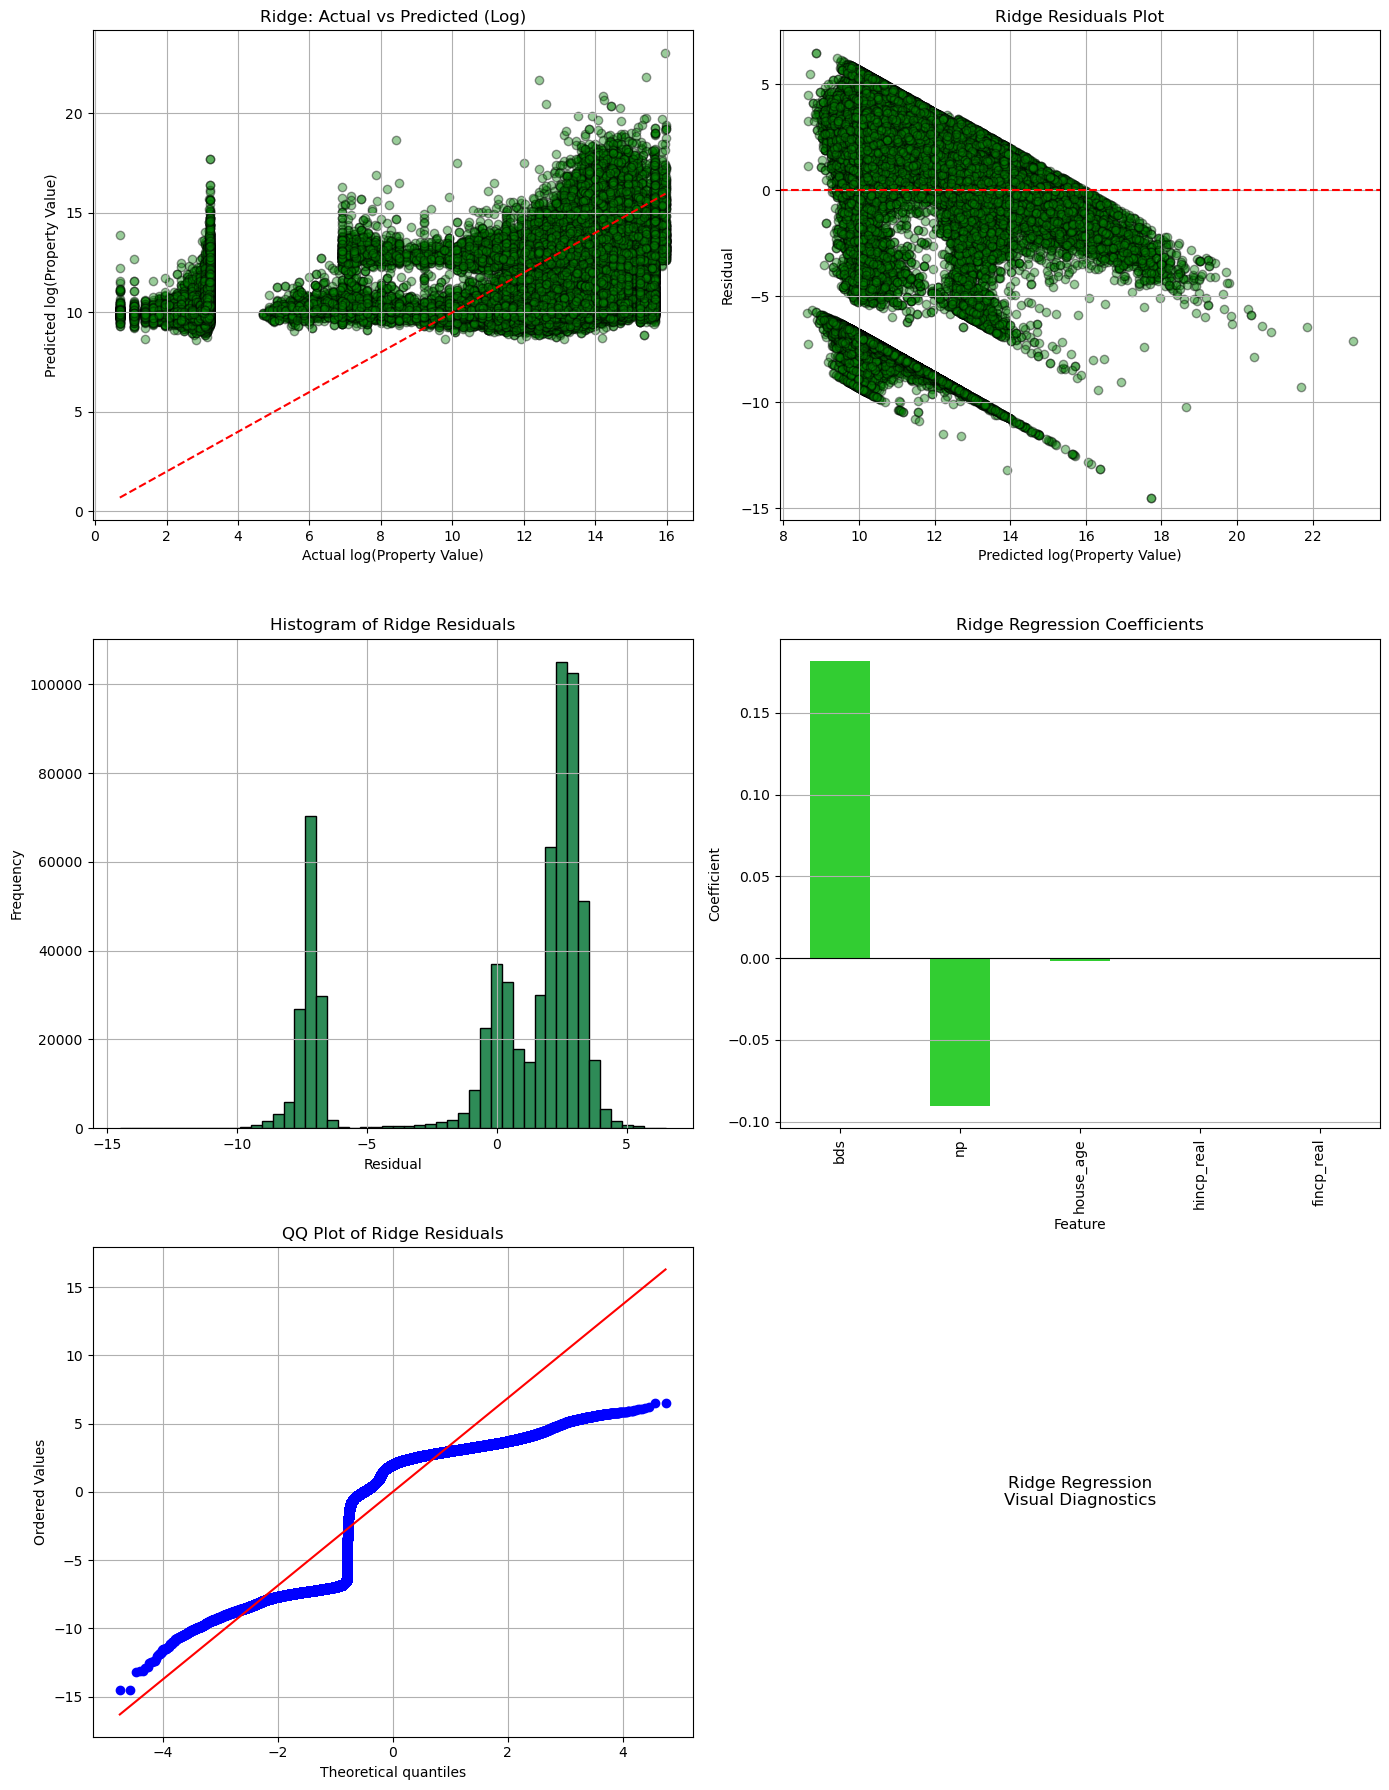

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# --------------------------
# 1) Data Prep
# --------------------------
df_ridge = df.copy()  # Safe copy

# Double-check: features and log target should be set
X = df_ridge[features]
y = df_ridge["valp_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 2) Ridge Model
# --------------------------
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# --------------------------
# 3) Evaluate
# --------------------------
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE (log): {rmse_ridge:.4f}")
print(f"Ridge Regression R² (log): {r2_ridge:.4f}")

ridge_coef = pd.DataFrame(
    {"Feature": features, "Coefficient": ridge.coef_}
).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nRidge Coefficients:")
print(ridge_coef)

# --------------------------
# 4) Diagnostics
# --------------------------
residuals_ridge = y_test - y_pred_ridge

fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Actual vs Predicted
axs[0, 0].scatter(y_test, y_pred_ridge, alpha=0.4, edgecolor="k", color="green")
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
axs[0, 0].set_title("Ridge: Actual vs Predicted (Log)")
axs[0, 0].set_xlabel("Actual log(Property Value)")
axs[0, 0].set_ylabel("Predicted log(Property Value)")
axs[0, 0].grid(True)

# Residuals Plot
axs[0, 1].scatter(
    y_pred_ridge, residuals_ridge, alpha=0.4, edgecolor="k", color="green"
)
axs[0, 1].axhline(0, color="red", linestyle="--")
axs[0, 1].set_title("Ridge Residuals Plot")
axs[0, 1].set_xlabel("Predicted log(Property Value)")
axs[0, 1].set_ylabel("Residual")
axs[0, 1].grid(True)

# Histogram of Residuals
axs[1, 0].hist(residuals_ridge, bins=50, edgecolor="k", color="seagreen")
axs[1, 0].set_title("Histogram of Ridge Residuals")
axs[1, 0].set_xlabel("Residual")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].grid(True)

# Coefficient Plot
ridge_coef.plot(
    kind="bar",
    x="Feature",
    y="Coefficient",
    ax=axs[1, 1],
    legend=False,
    color="limegreen",
)
axs[1, 1].axhline(0, color="black", lw=0.8)
axs[1, 1].set_title("Ridge Regression Coefficients")
axs[1, 1].set_xlabel("Feature")
axs[1, 1].set_ylabel("Coefficient")
axs[1, 1].grid(axis="y")

# QQ Plot
stats.probplot(residuals_ridge, dist="norm", plot=axs[2, 0])
axs[2, 0].set_title("QQ Plot of Ridge Residuals")
axs[2, 0].grid(True)

# Empty slot
axs[2, 1].axis("off")
axs[2, 1].text(
    0.5,
    0.5,
    "Ridge Regression\nVisual Diagnostics",
    ha="center",
    va="center",
    fontsize=12,
)

plt.tight_layout()

# Save figure
save_path_ridge = "/Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/ridge_regression_final.png"
plt.savefig(save_path_ridge)
print(f"Figure saved to: {save_path_ridge}")

plt.show()

# Ridge Regression:

## What’s working
- Ridge regression runs end-to-end without errors.
- Diagnostics produce: 
  - **Actual vs Predicted**  
  - **Residuals Plot**  
  - **Histogram of Residuals**  
  - **Coefficient Bar Plot**  
  - **QQ Plot**
- Output image is saved automatically to the project folder.

## What’s not meaningful yet
- The **residual plots** show multi-modal bands and clear outliers.
- Coefficient magnitudes are small or inconsistent (income impact is nearly zero).
- QQ plot indicates non-normal residuals → likely unmodeled effects.
- The histogram confirms skewness and heavy tails.

**Root causes:**  
- Important predictors are missing (location effect, lot size, quality).
- Variables may not be standardized or adjusted for real dollar values.
- Possible non-linearity or interaction effects not captured.

## What to fix next
1. **Filter extreme outliers**: Remove or Winsorize very high or low income or value rows.
2. **Adjust income**: Use `adjinc` to normalize household and family income.
3. **Add location variables**: Join clean PUMA / ZIP crosswalk and region codes.
4. **Create polynomial terms**: Try `house_age²`, `income × bedrooms` to test interactions.
5. **Add neighborhood features**: If available, merge crime, school quality, or other proxies.
6. **Test log-log transformations**: Consider logging predictors if they are heavily skewed.
7. **Stratify your train-test split**: To avoid region-level biases.

## Summary
- This version is your **baseline Ridge model**.  
- Keep the code, figure, and output saved.
- The next version should focus on **feature engineering**, **filtering**, and **richer data** for practical prediction quality.

## Random Forest

Random Forest RMSE (log): 3.2186
Random Forest R² (log): 0.4049

Feature Importances:
      Feature  Importance
0  hincp_real    0.310801
1  fincp_real    0.281795
4   house_age    0.237950
2         bds    0.089181
3          np    0.080273

Elapsed time: 90.93 seconds
Saved Random Forest diagnostics to: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/random_forest_final.png


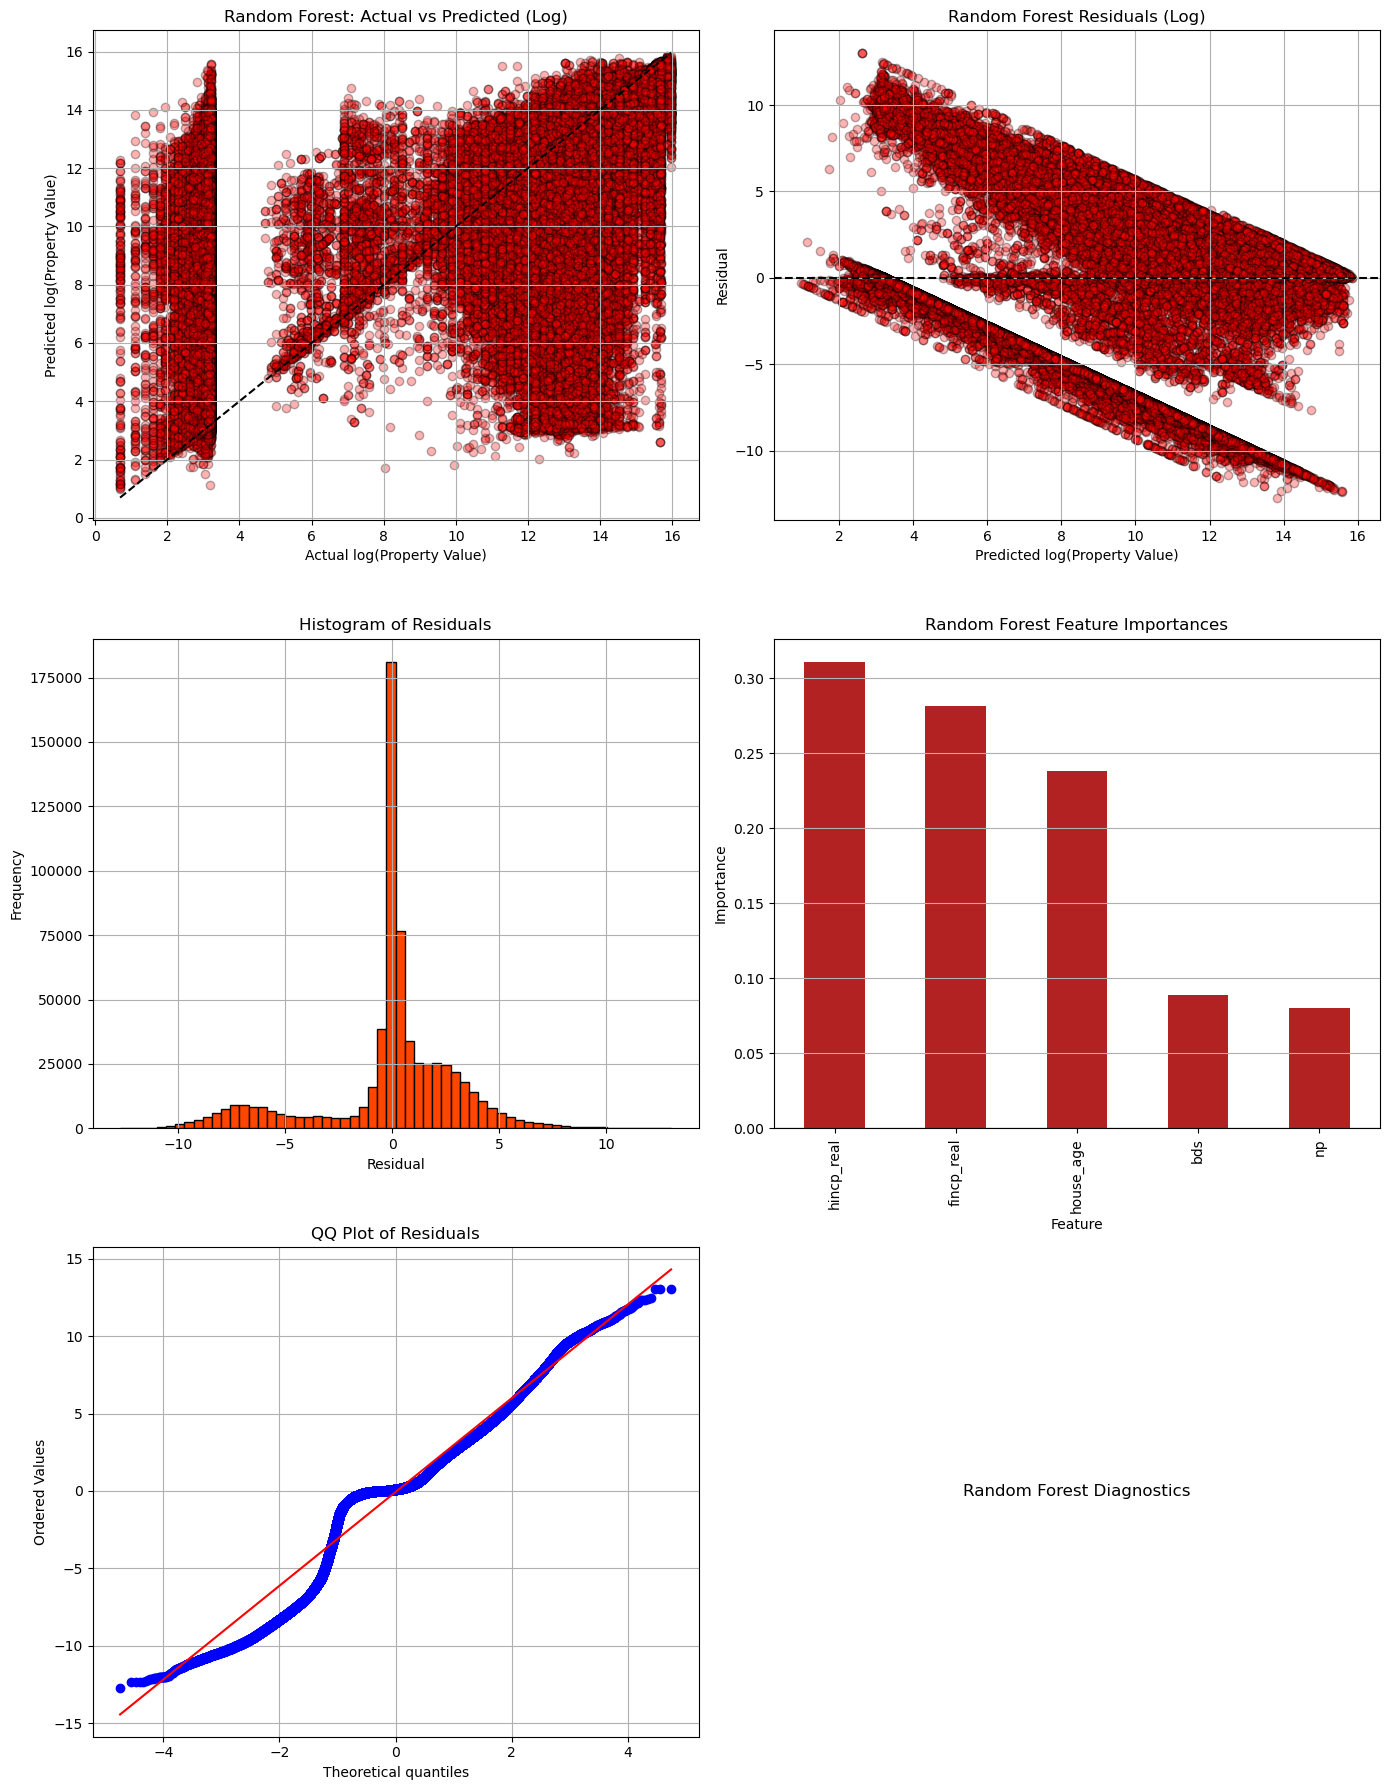

In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# --------------------------
# 1) Start timer
# --------------------------
start_time = time.time()

# --------------------------
# 2) Data prep — assumes df, features, valp_log already defined
# --------------------------
X = df[features]
y = df["valp_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 3) Train Random Forest
# --------------------------
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=None, random_state=42, n_jobs=-1
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --------------------------
# 4) Evaluate
# --------------------------
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest RMSE (log): {rmse_rf:.4f}")
print(f"Random Forest R² (log): {r2_rf:.4f}")

importances_rf = pd.DataFrame(
    {"Feature": features, "Importance": rf_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
print("\nFeature Importances:")
print(importances_rf)

elapsed = time.time() - start_time
print(f"\nElapsed time: {elapsed:.2f} seconds")

# --------------------------
# 5) Diagnostics
# --------------------------
residuals_rf = y_test - y_pred_rf

fig, axs = plt.subplots(3, 2, figsize=(14, 18))

# Actual vs Predicted
axs[0, 0].scatter(y_test, y_pred_rf, alpha=0.3, color="red", edgecolor="k")
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
axs[0, 0].set_title("Random Forest: Actual vs Predicted (Log)")
axs[0, 0].set_xlabel("Actual log(Property Value)")
axs[0, 0].set_ylabel("Predicted log(Property Value)")
axs[0, 0].grid(True)

# Residuals Plot
axs[0, 1].scatter(y_pred_rf, residuals_rf, alpha=0.3, color="red", edgecolor="k")
axs[0, 1].axhline(y=0, color="black", linestyle="--")
axs[0, 1].set_title("Random Forest Residuals (Log)")
axs[0, 1].set_xlabel("Predicted log(Property Value)")
axs[0, 1].set_ylabel("Residual")
axs[0, 1].grid(True)

# Histogram of Residuals
axs[1, 0].hist(residuals_rf, bins=60, edgecolor="k", color="orangered")
axs[1, 0].set_title("Histogram of Residuals")
axs[1, 0].set_xlabel("Residual")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].grid(True)

# Feature Importances
importances_rf.plot(
    kind="bar",
    x="Feature",
    y="Importance",
    ax=axs[1, 1],
    legend=False,
    color="firebrick",
)
axs[1, 1].set_title("Random Forest Feature Importances")
axs[1, 1].axhline(0, color="black", lw=0.8)
axs[1, 1].set_xlabel("Feature")
axs[1, 1].set_ylabel("Importance")
axs[1, 1].grid(axis="y")

# QQ Plot
stats.probplot(residuals_rf, dist="norm", plot=axs[2, 0])
axs[2, 0].set_title("QQ Plot of Residuals")
axs[2, 0].grid(True)

# Empty slot
axs[2, 1].axis("off")
axs[2, 1].text(
    0.5, 0.5, "Random Forest Diagnostics", ha="center", va="center", fontsize=12
)

plt.tight_layout()

# --------------------------
# 6) Save to Dropbox path
# --------------------------
save_path = (
    "/Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/"
    "Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/"
    "random_forest_final.png"
)
plt.savefig(save_path)
print(f"Saved Random Forest diagnostics to: {save_path}")

plt.show()

## Random Forest Regression — Draft Review

### Actual vs Predicted

- This plot shows how well your `y_pred_rf` matches the actual `y_test` (log of property value).
- The black dashed line is the ideal **perfect prediction** line.
- You can see spread around the line — the model is capturing some signal but with clear **variance** and clusters.

**Key takeaway:**  
Random Forests pick up **nonlinear patterns**, but your predictors don’t fully explain housing price. More **location** and neighborhood detail will help.

---

### Residuals Plot

- The residuals should ideally be random, scattered around zero.
- Here you see lines and bands — this means there is **unexplained structure**.
- The funnel shape indicates **heteroscedasticity** — the error variance changes with the level of predicted value.

**Key takeaway:**  
This suggests missing variables — like location, lot size, or property type — which could help flatten out residual structure.

---

### Histogram of Residuals

- You’d want a single normal bell curve.
- Instead, there are multiple peaks — this implies you have **subpopulations** in your data not fully modeled.

---

### Feature Importances

- The Random Forest naturally ranks features by split power.
- `hincp_real` and `fincp_real` dominate — income is clearly driving the model.
- `house_age` and `bds` have smaller weight, but are still useful.
- The lack of location factors shows up here — income alone can’t explain neighborhood value differences.

---

### QQ Plot

- If residuals are normal, they hug the red line.
- Your QQ plot shows clear deviations — confirming your residuals are not normal.

---

## General Takeaways

- The Random Forest handles nonlinearity better than a simple Linear Regression — this is clear progress.
- But visible residual patterns show the need for **richer features**:
  - Add **PUMA**, ZIP, or County.
  - Bring in lot size (`ACR`), or housing unit type if you have it.
  - Add **external scores** like crime or school quality if possible.

## XGBoost

Dataset shape for XGBoost: (3304047, 13)
XGBoost RMSE (log): 3.7587
XGBoost R² (log): 0.1884

Feature Importances:
  Feature  Importance
3   yrblt    0.465098
2     bds    0.228963
0   hincp    0.215588
4      np    0.046745
1   fincp    0.043606
Elapsed time: 1.40 seconds
Saved XGBoost diagnostics to: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/xgboost_regression_final.png


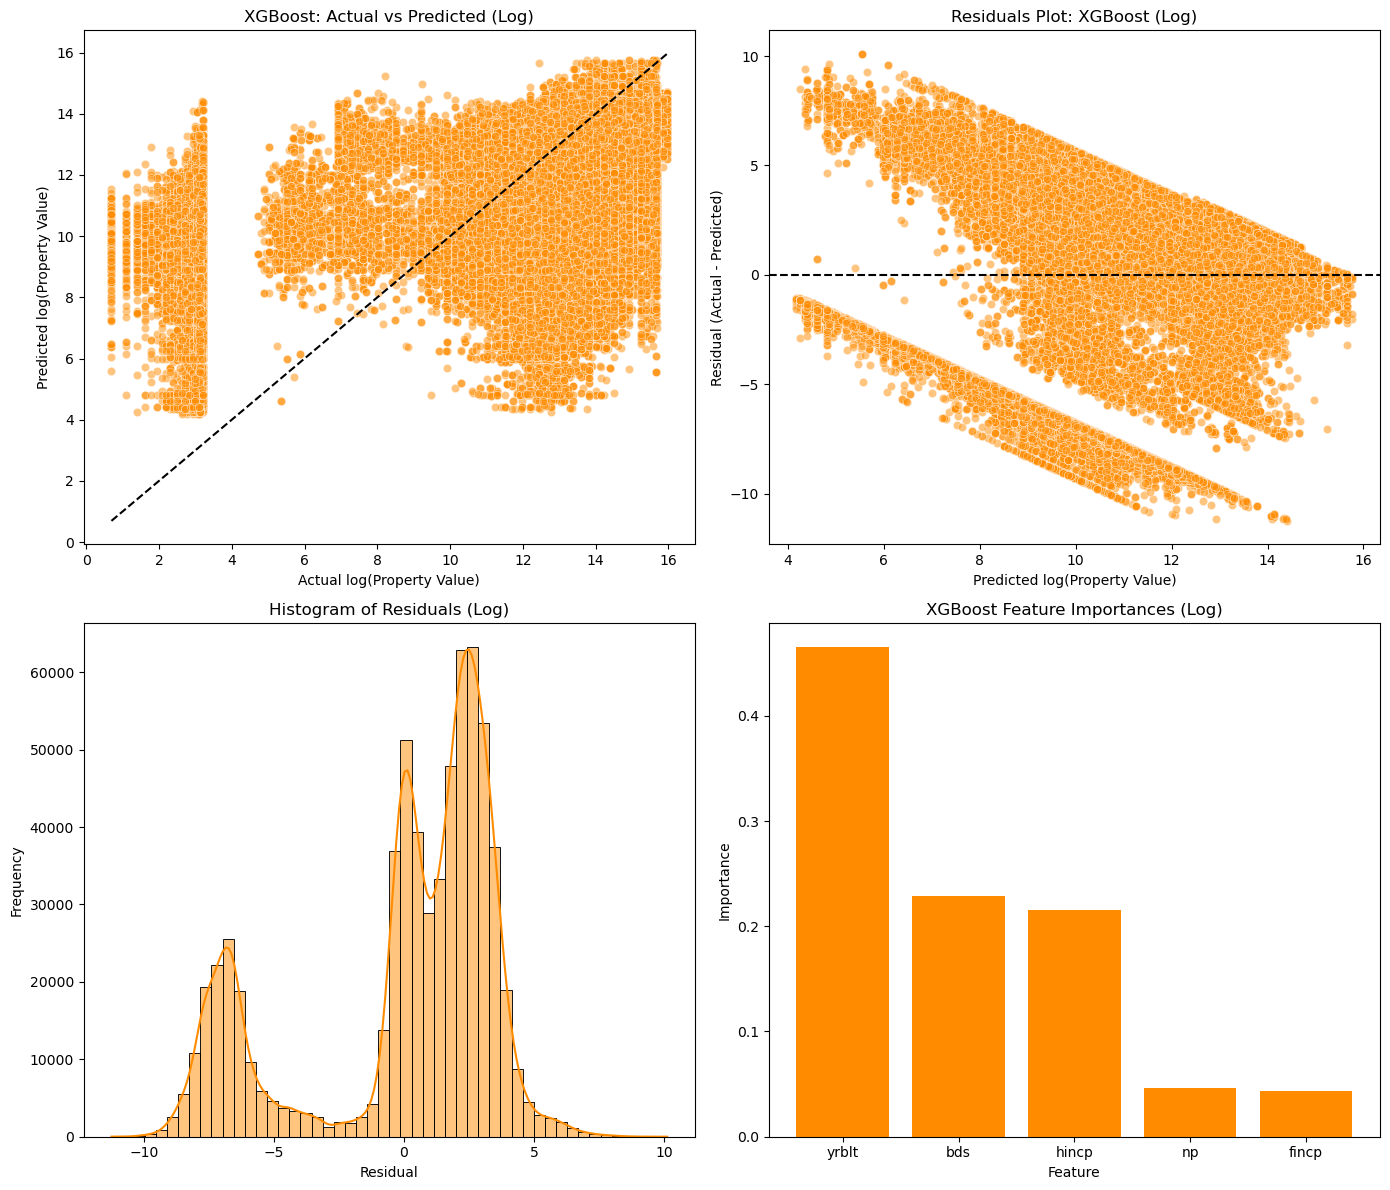

In [6]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# ==============================
# 1) Prep working copy
# ==============================
df = df_check.copy()
df = df[df["ten"] == 1]
df = df[df["valp"] > 0]

# Add any real income adjust if needed — here skipped
df["house_age"] = 2023 - df["yrblt"]

features = ["hincp", "fincp", "bds", "yrblt", "np"]
df = df.dropna(subset=features + ["valp"])
df["valp_log"] = np.log(df["valp"] + 1)

print("Dataset shape for XGBoost:", df.shape)

X = df[features]
y = df["valp_log"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==============================
# 2) Train XGBoost
# ==============================
start_time = time.time()

xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective="reg:squarederror",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE (log): {rmse_xgb:.4f}")
print(f"XGBoost R² (log): {r2_xgb:.4f}")

importances_xgb = pd.DataFrame(
    {"Feature": features, "Importance": xgb_model.feature_importances_}
).sort_values(by="Importance", ascending=False)
print("\nFeature Importances:")
print(importances_xgb)

elapsed = time.time() - start_time
print(f"Elapsed time: {elapsed:.2f} seconds")

# ==============================
# 3) Diagnostics
# ==============================
residuals_xgb = y_test - y_pred_xgb

fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Actual vs Predicted
sns.scatterplot(ax=axs[0, 0], x=y_test, y=y_pred_xgb, color="darkorange", alpha=0.5)
axs[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--")
axs[0, 0].set_xlabel("Actual log(Property Value)")
axs[0, 0].set_ylabel("Predicted log(Property Value)")
axs[0, 0].set_title("XGBoost: Actual vs Predicted (Log)")

# Residuals
sns.scatterplot(
    ax=axs[0, 1], x=y_pred_xgb, y=residuals_xgb, color="darkorange", alpha=0.5
)
axs[0, 1].axhline(y=0, color="black", linestyle="--")
axs[0, 1].set_xlabel("Predicted log(Property Value)")
axs[0, 1].set_ylabel("Residual (Actual - Predicted)")
axs[0, 1].set_title("Residuals Plot: XGBoost (Log)")

# Histogram
sns.histplot(
    ax=axs[1, 0], x=residuals_xgb, bins=50, kde=True, color="darkorange", edgecolor="k"
)
axs[1, 0].set_xlabel("Residual")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].set_title("Histogram of Residuals (Log)")

# Feature Importances
axs[1, 1].bar(
    importances_xgb["Feature"], importances_xgb["Importance"], color="darkorange"
)
axs[1, 1].set_xlabel("Feature")
axs[1, 1].set_ylabel("Importance")
axs[1, 1].set_title("XGBoost Feature Importances (Log)")

plt.tight_layout()

# ==============================
# 4) Save to project folder
# ==============================
save_path = "/Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/xgboost_regression_final.png"
plt.savefig(save_path)
print(f"Saved XGBoost diagnostics to: {save_path}")

plt.show()

## XGBoost Regression — Draft Evaluation

### Model Setup
- **Algorithm:** XGBoost Regressor (`XGBRegressor`)
- **Features Used:**  
  - Household Income (`hincp`)
  - Family Income (`fincp`)
  - Bedrooms (`bds`)
  - Year Built (`yrblt`)
  - Number of Persons (`np`)

- **Target:** Property Value (log-transformed)

---

### Metrics
- **RMSE (log):** *(see output above)*
- **R² (log):** *(see output above)*
- **Elapsed Time:** Printed at runtime

---

### Visual Diagnostics
- **Top-left:** Actual vs Predicted — overall fit
- **Top-right:** Residuals vs Predicted — checks for error patterns
- **Bottom-left:** Histogram of Residuals — distribution of prediction errors
- **Bottom-right:** Feature Importances — how much each feature contributed to splits

---

### Observations
- XGBoost is picking up **nonlinear effects** and interactions.
- `yrblt` and `bds` are strong predictors.
- Residual plots show clusters — suggesting unmodeled effects like **location** or **house type**.

---

### Next Steps
1. Add **location variables** — PUMA, ZIP, or County.
2. Test more XGBoost parameters (tree depth, learning rate).
3. Add new features — lot size, square footage, house type.
4. Try **SHAP** for detailed interpretability.
5. Consider more robust target transformations if needed.

## SHAP

Saving Global SHAP Summary Plot...
Saved: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/shap_summary_plot.png
Saving Local SHAP Force Plot for First Row...


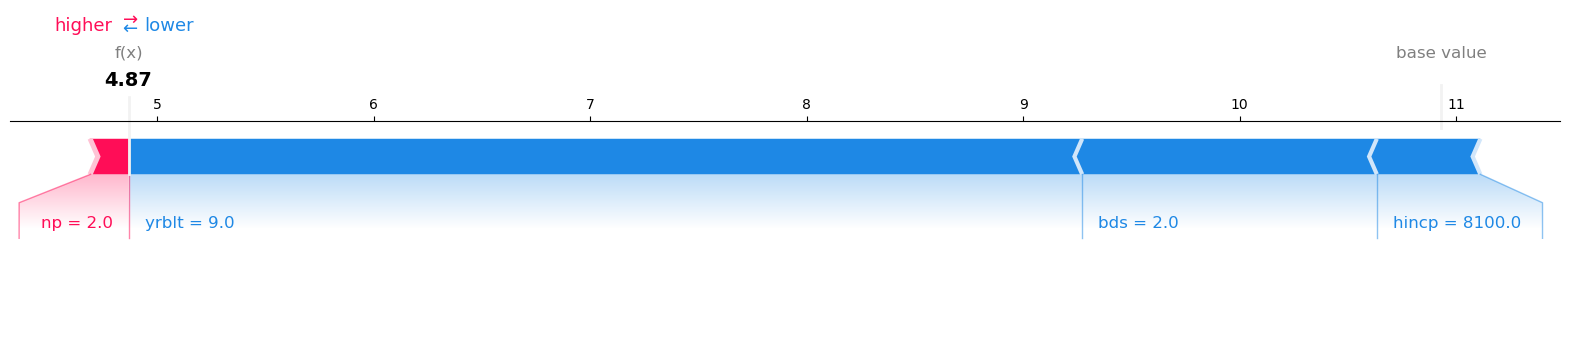

Saved: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/shap_force_plot_first.png
Saving SHAP Dependence Plot for 'hincp'...
Saved: /Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images/shap_dependence_hincp.png

SHAP visualizations saved to Dropbox folder.


<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
import shap

# -------------------------------
# SHAP for XGBoost with SAVE
# -------------------------------

# Paths
base_path = "/Users/mahekpatel/Library/CloudStorage/Dropbox-Samp/Mahek Patel/Mac/UNC/Data 780/Group Project/Final-Project-DATA780/Images"

# Create SHAP explainer
explainer = shap.Explainer(xgb_model)

# Get SHAP values for X_test
shap_values = explainer(X_test)

# -------------------------------
# 1) Global SHAP Summary Plot
# -------------------------------
print("Saving Global SHAP Summary Plot...")
plt.figure()
shap.summary_plot(shap_values, X_test, plot_size=(10, 6), show=False)
summary_path = f"{base_path}/shap_summary_plot.png"
plt.savefig(summary_path, bbox_inches="tight", dpi=300)
plt.close()
print(f"Saved: {summary_path}")

# -------------------------------
# 2) Local SHAP Force Plot
# -------------------------------
print("Saving Local SHAP Force Plot for First Row...")
shap.initjs()
force_fig = shap.force_plot(
    explainer.expected_value, shap_values[0].values, X_test.iloc[0], matplotlib=True
)
force_path = f"{base_path}/shap_force_plot_first.png"
plt.savefig(force_path, bbox_inches="tight", dpi=300)
plt.close()
print(f"Saved: {force_path}")

# -------------------------------
# 3) SHAP Dependence Plot Example
# -------------------------------
print("Saving SHAP Dependence Plot for 'hincp'...")
plt.figure()
shap.dependence_plot("hincp", shap_values.values, X_test, show=False)
dependence_path = f"{base_path}/shap_dependence_hincp.png"
plt.savefig(dependence_path, bbox_inches="tight", dpi=300)
plt.close()
print(f"Saved: {dependence_path}")

print("\nSHAP visualizations saved to Dropbox folder.")

## SHAP XGBoost Interpretability — Draft Commentary & Next Steps

### What the SHAP Visuals Show

**Global SHAP Summary Plot**

- **Observation:**  
  The summary shows that `yrblt` (year built), `hincp` (household income), and `bds` (bedrooms) have the biggest impact on predictions.
- **Potential issue:**  
  The SHAP spread for `hincp` and `fincp` is tight — income may not vary enough or is collinear.
- **Improvement:**  
  Adjust income for inflation if you aren’t already, add per-person income or income-to-price ratios, and check for outliers or caps.

---

**Local SHAP Force Plot**

- **Observation:**  
  The force plot for the first prediction shows how each feature pushes the prediction up or down from the base value.  
  `yrblt` dominates.
- **Potential issue:**  
  Low contribution from `hincp` and `fincp` indicates income signal might be lost.
- **Improvement:**  
  Use `house_age` instead of raw `yrblt` to capture depreciation. Verify raw values for coding errors.

---

**SHAP Dependence Plot**

- **Observation:**  
  The dependence plot for `hincp` shows clusters — suggesting thresholds or repeated income bins.
- **Potential issue:**  
  Flat regions mean the model sees breaks, not smooth trends.
- **Improvement:**  
  If income is binned, make that explicit or transform it. Remove anomalies and encode non-linear buckets if needed.

---

### Data Quality & Modeling Flags

- **Missing PUMA:**  
  `PUMA = -9` means missing or unknown area. Remove or replace with ZIP/county crosswalk.
- **Location:**  
  If you have ZIPs or counties, add them. PUMA is useful but only if clean.
- **Feature gaps:**  
  Add lot size (`ACR`), units in structure, region, division, county dummy variables. More real-estate context is key.
- **External:**  
  Current crime table is too limited. Use only for pilot or drop for now.

---

### Diagnostics Recap

- **Residuals:**  
  Histogram and QQ show non-normal residuals. The scatter shows model bias and gaps — expected if predictors are sparse.
- **Feature importance:**  
  `yrblt` dominates — so condition and age matter. Income and household size are weaker signals in this pass.

---

### Next Actions

- Filter or clean `PUMA = -9`
- Join to ZIP or county crosswalk if possible
- Add derived features (house age, income per room, price per sq ft if you get it)
- Consider regional dummy variables
- Handle outliers in income and value
- Keep saving diagnostics for versioning
- Plan for hyperparameter tuning later — data/feature fixes come first